In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os, sys
from scipy.signal import savgol_filter, find_peaks
from datetime import datetime, timedelta
sys.path.append('../modules/')
import image_handler
import run_handler

In [2]:
campaign = run_handler.Campaign('../configs/TestCampaign01.json')

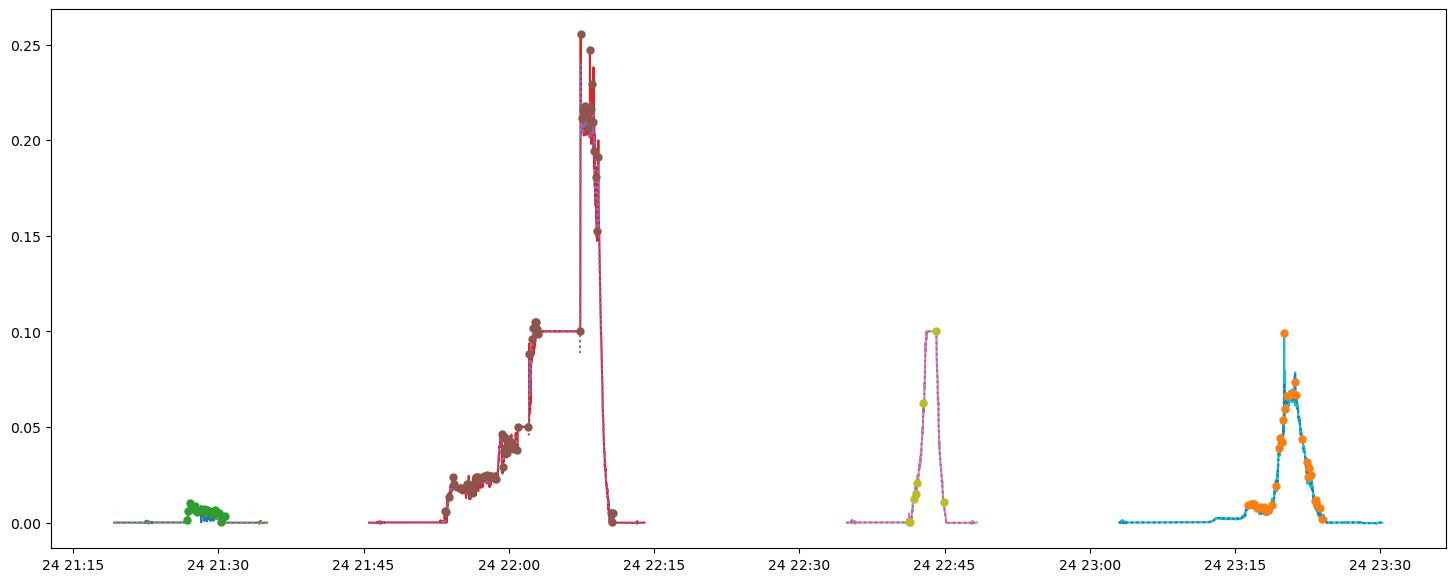

In [3]:
# weird current artifacts at the beginning
cut_value = -5
currents = []
filtered_currents = []
hv_times = []
peaks = []
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, ax = plt.subplots(1, 1, figsize=(18, 7))
for i, run in enumerate(campaign.runs):
    run.load_image_data()
    current = np.array(run.hv_data['current'])
    current = -1. * np.where(current > cut_value, current, 0)
    filtered_current = savgol_filter(current, window_length=11, polyorder=5)
    peak_ids, _ = find_peaks(filtered_current, distance=5, prominence=0.001)
    peaks.append(peak_ids)
    hv_time = np.array(run.hv_data['time'])
    ax.plot(hv_time, current)
    ax.plot(hv_time, filtered_current, linestyle=':')
    ax.plot(hv_time[peak_ids], current[peak_ids], linestyle='none', marker='o', markersize=5)
    currents.append(current)
    filtered_currents.append(filtered_current)
    hv_times.append(hv_time)

In [4]:
pics_before_peak = []
dts_to_peak = []
for irun, run in enumerate(campaign.runs):
    image_times = run.image_data['time']
    for ipeak, peak_id in enumerate(peaks[irun]):
        t_this = hv_times[irun][peak_id]
        corresponding_img_id = np.searchsorted(image_times, t_this)
        if corresponding_img_id == 0:
            continue
        # we want all pictures 20s before the peak
        pic = run.pictures[corresponding_img_id - 1]
        if (pic.time < t_this + np.timedelta64(5, 's')) & (pic.time + timedelta(seconds=pic.exposure) > t_this - np.timedelta64(20, 's')):
            pics_before_peak.append(pic)
            dt = (pic.time + timedelta(seconds=pic.exposure*0.5)) - t_this
            dts_to_peak.append(dt.total_seconds())
print(len(pics_before_peak))

37


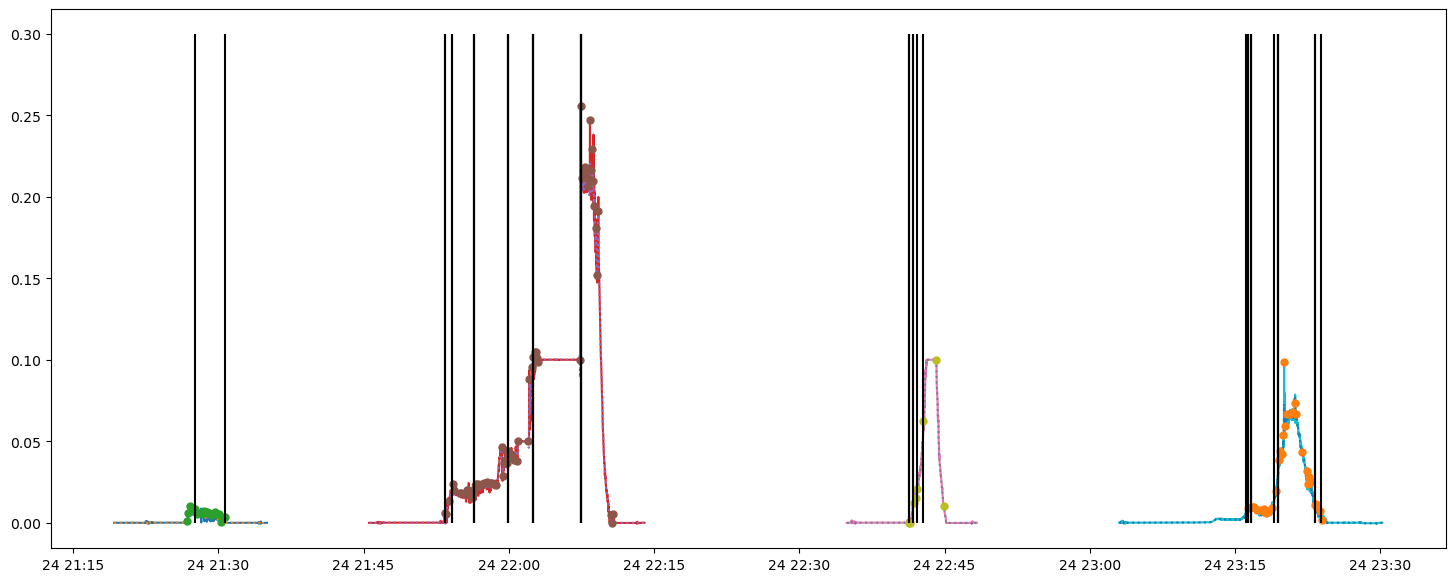

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(18, 7))
for i, run in enumerate(campaign.runs):
    ax.plot(hv_times[i], currents[i])
    ax.plot(hv_times[i], filtered_currents[i], linestyle=':')
    ax.plot(hv_times[i][peaks[i]], currents[i][peaks[i]], linestyle='none', marker='o', markersize=5)
ax.vlines(x=[pic.time for pic in pics_before_peak], ymin=0, ymax=0.3, linestyle='-', color='black')

In [6]:
for pic in pics_before_peak:
    pic.get_contour_data()

In [7]:
collective_masses = np.zeros(len(pics_before_peak))
n_clusters = np.zeros(len(pics_before_peak))
max_cluster_areas = np.zeros(len(pics_before_peak))
exposures = np.zeros(len(pics_before_peak))
for i, pic in enumerate(pics_before_peak):
    exposures[i] = pic.exposure
    collective_masses[i] = sum(pic.contour_masses)
    n_clusters[i] = len(pic.contour_masses)
    if n_clusters[i] != 0:
        max_cluster_areas[i] = max(pic.contour_masses)
dts_to_peak = np.array(dts_to_peak)
log_masses = np.log10(collective_masses, out=np.zeros_like(collective_masses), where=(collective_masses != 0))
log_max_area = np.log10(max_cluster_areas, out=np.zeros_like(max_cluster_areas), where=(max_cluster_areas != 0))

In [8]:
t_bin_edges = np.arange(-27.5, 10.5, 5)
t_bin_edges

array([-27.5, -22.5, -17.5, -12.5,  -7.5,  -2.5,   2.5,   7.5])

In [9]:
ids_5 = np.where(exposures == 5)[0]
ids_10 = np.where(exposures == 10)[0]
ids_20 = np.where(exposures == 20)[0]
ids_other = np.array([i for i, t in enumerate(exposures) if t not in [5, 10, 20]])

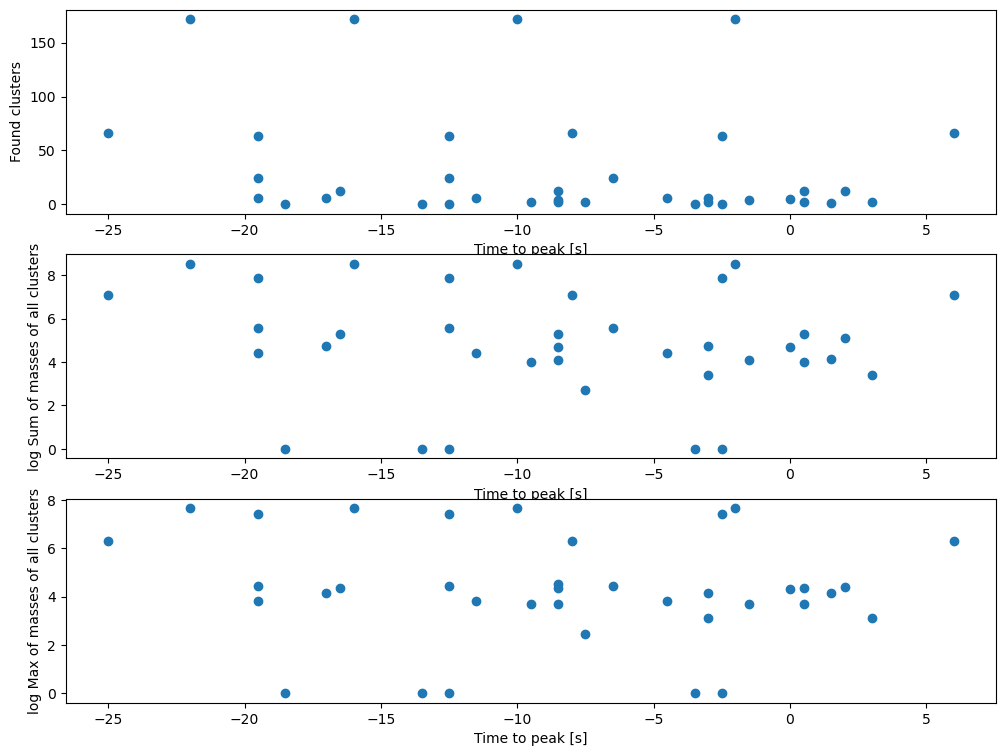

In [10]:
fig, ax = plt.subplots(3, 1, figsize=(12, 9))
ax[0].plot(dts_to_peak, n_clusters, linestyle='none', marker='o')
ax[0].set_xlabel('Time to peak [s]')
ax[0].set_ylabel('Found clusters')
ax[1].plot(dts_to_peak, log_masses, linestyle='none', marker='o')
ax[1].set_xlabel('Time to peak [s]')
ax[1].set_ylabel('log Sum of masses of all clusters')
ax[2].plot(dts_to_peak, log_max_area, linestyle='none', marker='o')
ax[2].set_xlabel('Time to peak [s]')
ax[2].set_ylabel('log Max of masses of all clusters')
plt.show()

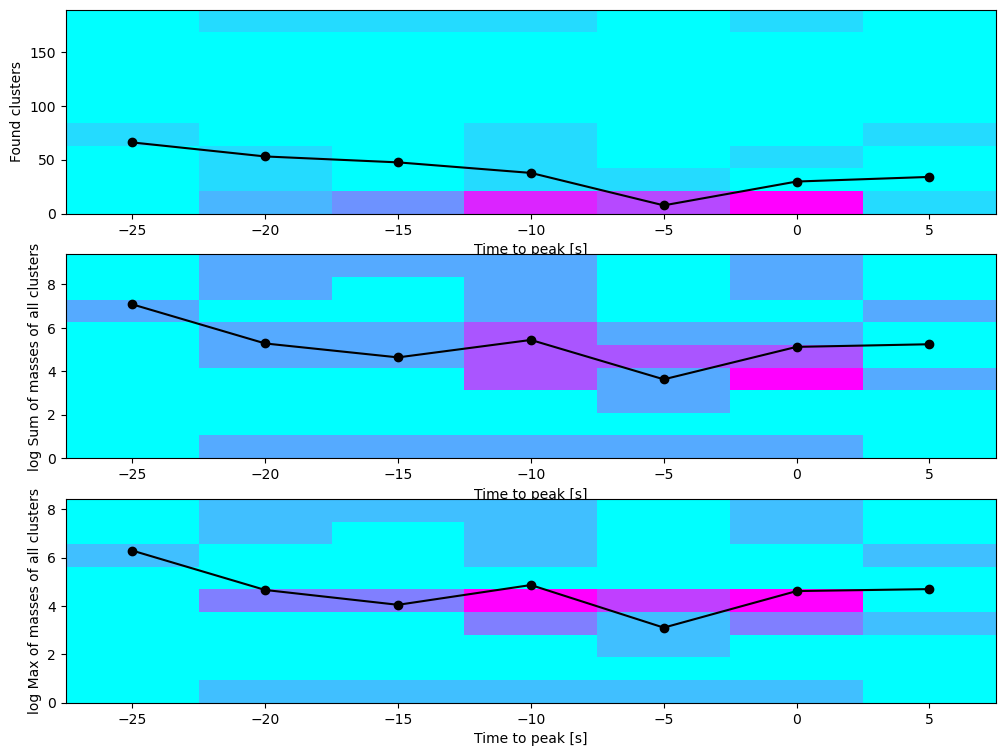

In [11]:
fig, ax = plt.subplots(3, 1, figsize=(12, 9))
ax[0].hist2d(dts_to_peak, n_clusters, bins=[t_bin_edges, np.linspace(0, 1.1*np.max(n_clusters), 10)], cmap='cool')
ax[0].plot(t_bin_edges[:-1]+2.5, [np.mean(n_clusters[(t < dts_to_peak) & (dts_to_peak < t_bin_edges[i+1])]) for i, t in enumerate(t_bin_edges[:-1])], color='black', marker='o')
ax[0].set_xlabel('Time to peak [s]')
ax[0].set_ylabel('Found clusters')
ax[1].hist2d(dts_to_peak, log_masses, bins=[t_bin_edges, np.linspace(0, 1.1*np.max(log_masses), 10)], cmap='cool')
ax[1].plot(t_bin_edges[:-1]+2.5, [np.mean(log_masses[(t < dts_to_peak) & (dts_to_peak < t_bin_edges[i+1])]) for i, t in enumerate(t_bin_edges[:-1])], color='black', marker='o')
ax[1].set_xlabel('Time to peak [s]')
ax[1].set_ylabel('log Sum of masses of all clusters')
ax[2].hist2d(dts_to_peak, log_max_area, bins=[t_bin_edges, np.linspace(0, 1.1*np.max(log_max_area), 10)], cmap='cool')
ax[2].plot(t_bin_edges[:-1]+2.5, [np.mean(log_max_area[(t < dts_to_peak) & (dts_to_peak < t_bin_edges[i+1])]) for i, t in enumerate(t_bin_edges[:-1])], color='black', marker='o')
ax[2].set_xlabel('Time to peak [s]')
ax[2].set_ylabel('log Max of masses of all clusters')
plt.show()

# First large scale current transition

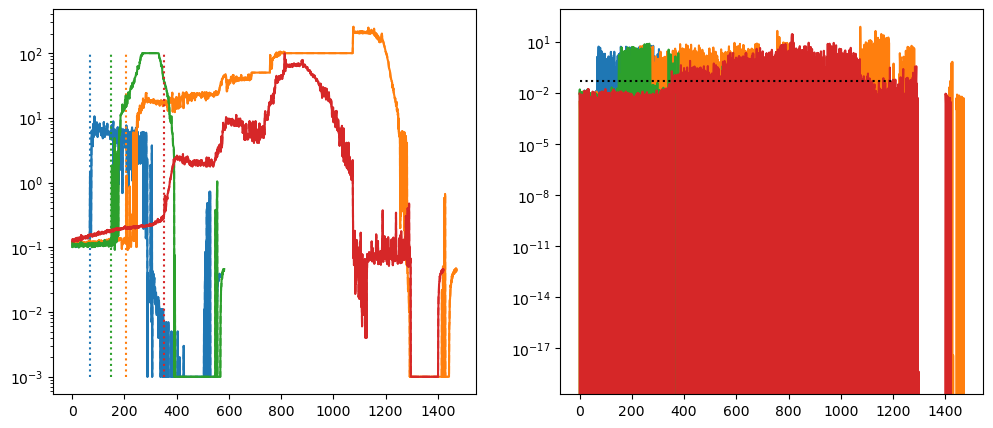

In [12]:
t_transition = []
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
for i, run in enumerate(campaign.runs):
    voltage = -1.*run.hv_data['voltage']
    ramp_start_id = np.argmax(voltage > 10000)
    abs_time = run.hv_data['time'].values[ramp_start_id:]
    t0 = abs_time[0]
    time = (abs_time - t0) / np.timedelta64(1, 's')
    current = np.clip(-1*run.hv_data['current'][ramp_start_id:]  * 1e3, a_min=1e-3, a_max=np.inf)
    smoothed_current = savgol_filter(current, window_length=5, polyorder=4)
    dc = np.diff(smoothed_current)
    dc_threshold = 5e-2
    dc_thresh_id = np.argmax(dc > dc_threshold)
    dt = time[dc_thresh_id]
    t_transition.append(abs_time[dc_thresh_id])
    ax[0].plot(time, current, color=colors[i])
    ax[0].plot(time, smoothed_current, linestyle='--', color=colors[i])
    ax[0].vlines(x=dt, ymin=1e-3, ymax=1e2, linestyle=':', color=colors[i])
    ax[1].plot(time[:-1], dc, color=colors[i])
ax[1].hlines(y=dc_threshold, xmin=0, xmax=1200, color='black', linestyle=':')
ax[0].set_yscale('log')
ax[1].set_yscale('log')

In [13]:
pics_around_transition = []
dts_to_transition = []
for i, run in enumerate(campaign.runs):
    for pic in run.pictures:
        if (pic.time < t_transition[i] + np.timedelta64(5, 's')) & (pic.time + timedelta(seconds=pic.exposure) > t_transition[i] - np.timedelta64(20, 's')):
            dt = pic.time + timedelta(.5*pic.exposure) - t_transition[i]
            pics_around_transition.append(pic)
            dts_to_transition.append(dt)
print(len(pics_around_transition))

4


In [14]:
for pic in pics_around_transition:
    pic.get_contour_data()

In [15]:
collective_masses = np.zeros(len(pics_around_transition))
n_clusters = np.zeros(len(pics_around_transition))
max_cluster_areas = np.zeros(len(pics_around_transition))
exposures = np.zeros(len(pics_around_transition))
for i, pic in enumerate(pics_around_transition):
    exposures[i] = pic.exposure
    collective_masses[i] = sum(pic.contour_masses)
    n_clusters[i] = len(pic.contour_masses)
    if n_clusters[i] != 0:
        max_cluster_areas[i] = max(pic.contour_masses)
dts_to_transition = np.array(dts_to_transition)
log_masses = np.log10(collective_masses, out=np.zeros_like(collective_masses), where=(collective_masses != 0))
log_max_area = np.log10(max_cluster_areas, out=np.zeros_like(max_cluster_areas), where=(max_cluster_areas != 0))

In [17]:
[t.total_seconds() for t in dts_to_transition]

[431992.0, 215977.0, 215992.0, 216003.0]

TypeError: '<' not supported between instances of 'float' and 'Timedelta'

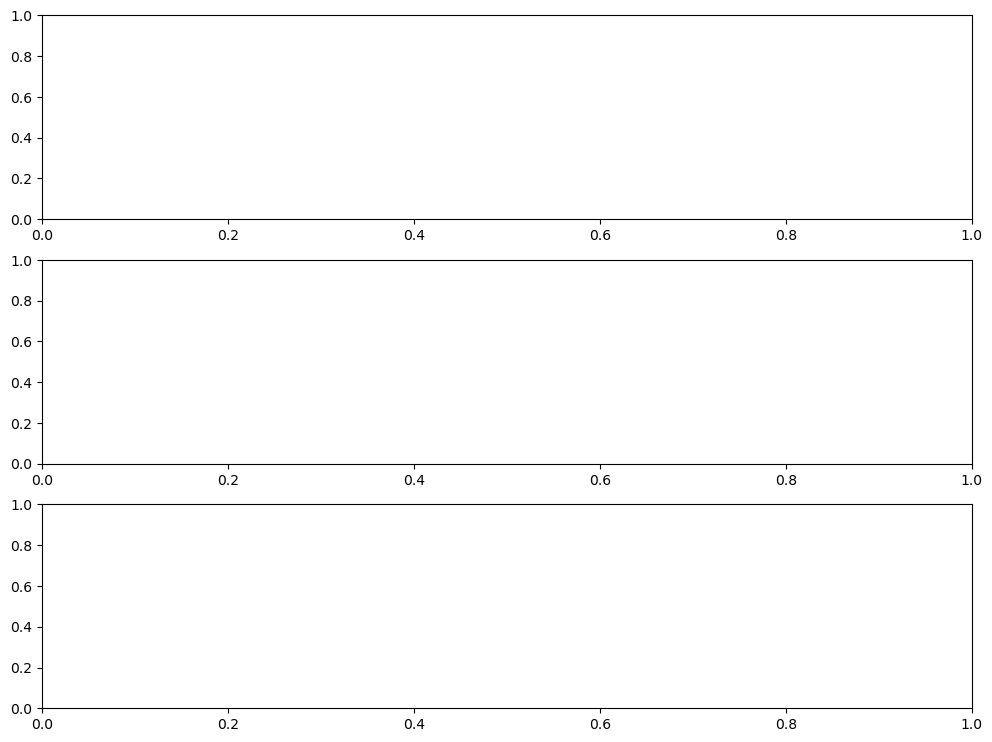

In [16]:
fig, ax = plt.subplots(3, 1, figsize=(12, 9))
ax[0].hist2d(dts_to_transition, n_clusters, bins=[t_bin_edges, np.linspace(0, 1.1*np.max(n_clusters), 10)], cmap='cool')
ax[0].plot(t_bin_edges[:-1]+2.5, [np.mean(n_clusters[(t < dts_to_transition) & (dts_to_transition < t_bin_edges[i+1])]) for i, t in enumerate(t_bin_edges[:-1])], color='black', marker='o')
ax[0].set_xlabel('Time to current transition [s]')
ax[0].set_ylabel('Found clusters')
ax[1].hist2d(dts_to_transition, log_masses, bins=[t_bin_edges, np.linspace(0, 1.1*np.max(log_masses), 10)], cmap='cool')
ax[1].plot(t_bin_edges[:-1]+2.5, [np.mean(log_masses[(t < dts_to_transition) & (dts_to_transition < t_bin_edges[i+1])]) for i, t in enumerate(t_bin_edges[:-1])], color='black', marker='o')
ax[1].set_xlabel('Time to current transition [s]')
ax[1].set_ylabel('log Sum of masses of all clusters')
ax[2].hist2d(dts_to_transition, log_max_area, bins=[t_bin_edges, np.linspace(0, 1.1*np.max(log_max_area), 10)], cmap='cool')
ax[2].plot(t_bin_edges[:-1]+2.5, [np.mean(log_max_area[(t < dts_to_transition) & (dts_to_transition < t_bin_edges[i+1])]) for i, t in enumerate(t_bin_edges[:-1])], color='black', marker='o')
ax[2].set_xlabel('Time to current transition [s]')
ax[2].set_ylabel('log Max of masses of all clusters')
plt.show()